<a href="https://colab.research.google.com/github/lszam/geodata-processing/blob/main/csv2numeric_tif_4grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.2 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# === 1. Carregar CSV ===
csv_path = 'bat.csv'
df = pd.read_csv(csv_path)

# === 2. Verificar colunas ===
print(df.columns)
# Renomear
#df = df.rename(columns={'x': 'lon', 'y': 'lat', 'z': 'elevation'})

# === 3. Determinar resolução do grid ===
df_sorted = df.sort_values(by=['Y', 'X'], ascending=[False, True])
lon_vals = np.unique(np.round(df['X'], 6))
lat_vals = np.unique(np.round(df['Y'], 6))[::-1]  # ordem decrescente (norte → sul)

n_cols = len(lon_vals)
n_rows = len(lat_vals)

# === 4. Matriz 2D ===
elevation_grid = df_sorted['BAT'].values.reshape((n_rows, n_cols))

# === 5. Transformação affine ===
cellsize_x = np.abs(lon_vals[1] - lon_vals[0])
cellsize_y = np.abs(lat_vals[1] - lat_vals[0])
transform = from_origin(lon_vals[0], lat_vals[0], cellsize_x, cellsize_y)

# === 6. Salvar Geotiff ===
geotiff_path = "bat.tif"
with rasterio.open(
    geotiff_path,
    "w",
    driver="GTiff",
    height=n_rows,
    width=n_cols,
    count=1,
    dtype=elevation_grid.dtype,
    #crs="EPSG:4326",  # WGS84
    crs="EPSG:5880",  # Polic Sirgas2000
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(elevation_grid, 1)

print(f"Arquivo salvo em: {geotiff_path}")


Index(['BAT', 'X', 'Y'], dtype='object')


ValueError: cannot reshape array of size 1296441 into shape (1296439,1296439)

In [11]:
import numpy as np
import pandas as pd


df = pd.read_csv('bat.csv')
df['Xr'] = df['X'].round(6)
df['Yr'] = df['Y'].round(6)

lon_vals = np.sort(df['Xr'].unique())         # crescente
lat_vals = np.sort(df['Yr'].unique())[::-1]   # decrescente (norte → sul)

dx = 2000
dy = 2000

n_cols = int(round((lon_vals.max() - lon_vals.min())/dx)) + 1
n_rows = int(round((lat_vals.max() - lat_vals.min())/dy)) + 1

print(f"Grid resolution: dx={dx}, dy={dy}")
print(f"Grid shape: {n_rows} rows x {n_cols} cols")

# Mapear cada ponto df → índice (ix, iy)
#    ix: 0 ... n_cols-1,    iy: 0 ... n_rows-1 (0 no topo)
ix = np.floor((df['Xr'] - lon_vals.min()) / dx + 0.5).astype(int)
iy = np.floor((lat_vals.max() - df['Yr']) / dy + 0.5).astype(int)

# Preencher grid com NaNs e depois com BAT
elevation_grid = np.full((n_rows, n_cols), np.nan)
elevation_grid[iy, ix] = df['BAT'].values

print("Elevation grid array shape:", elevation_grid.shape)


Grid resolution: dx=2000, dy=2000
Grid shape: 624 rows x 703 cols
Elevation grid array shape: (624, 703)


In [13]:
import rasterio
from rasterio.transform import from_origin

# Affine transform: top-left corner at (min_lon, max_lat)
transform = from_origin(
    west=lon_vals.min(),
    north=lat_vals.max(),
    xsize=dx,
    ysize=dy
)

# Create and write the GeoTIFF
output_path = "bat.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=elevation_grid.shape[0],
    width=elevation_grid.shape[1],
    count=1,
    dtype=elevation_grid.dtype,
    #crs="EPSG:4326",  # WGS84
    crs="EPSG:5880",  # Polic Sirgas2000
    transform=transform,
) as dst:
    dst.write(elevation_grid, 1)

print(f"GeoTIFF saved to: {output_path}")


GeoTIFF saved to: bat.tif


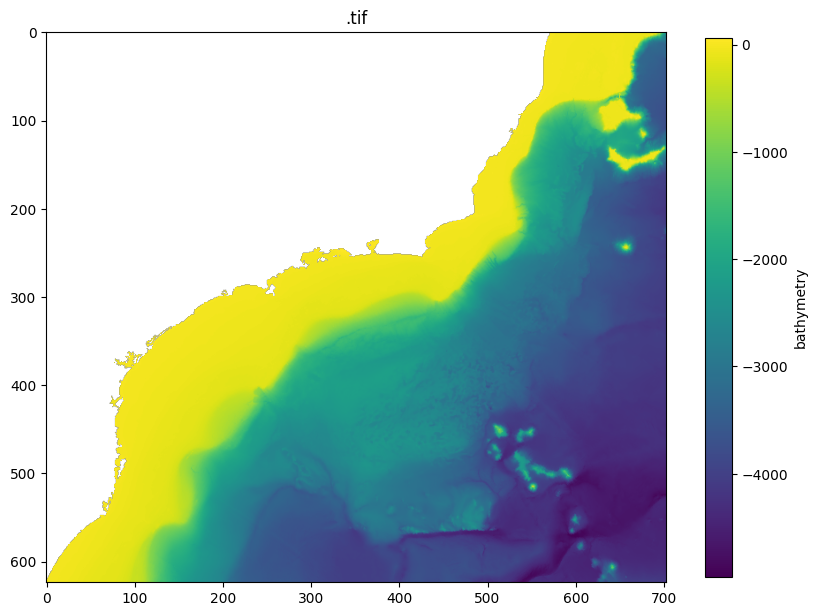

In [19]:
with rasterio.open(output_path) as src:
    plt.figure(figsize=(10, 10))
    plt.imshow(src.read(1), cmap='viridis')
    plt.colorbar(label='bathymetry', shrink=0.7)
    plt.title('.tif')
    plt.show()

In [18]:
import rasterio

# Open the GeoTIFF file
with rasterio.open(output_path) as src:
    # Print the Coordinate Reference System (CRS)
    print(f"The CRS of bat.tif is: {src.crs}")

The CRS of bat.tif is: EPSG:5880
